# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from importlib import reload

# Data loading

In [2]:
data = pd.read_csv('loan.csv')
data.shape

(39717, 111)

# Data cleaning

#### 1. Fix columns
###### 1.1 Find all the columns where more than 50% records are empty

In [3]:
colms_with_more_than_half_nulls = data.columns[data.isnull().mean()*100 > 50]
round(data[colms_with_more_than_half_nulls].isnull().mean()*100, 2)

mths_since_last_delinq             64.66
mths_since_last_record             92.99
next_pymnt_d                       97.13
mths_since_last_major_derog       100.00
annual_inc_joint                  100.00
dti_joint                         100.00
verification_status_joint         100.00
tot_coll_amt                      100.00
tot_cur_bal                       100.00
open_acc_6m                       100.00
open_il_6m                        100.00
open_il_12m                       100.00
open_il_24m                       100.00
mths_since_rcnt_il                100.00
total_bal_il                      100.00
il_util                           100.00
open_rv_12m                       100.00
open_rv_24m                       100.00
max_bal_bc                        100.00
all_util                          100.00
total_rev_hi_lim                  100.00
inq_fi                            100.00
total_cu_tl                       100.00
inq_last_12m                      100.00
acc_open_past_24

##### 1.2 Delete all the columns where more than 50% records are empty

In [4]:
data = data.drop(columns = colms_with_more_than_half_nulls, axis = 1)

In [5]:
data.shape

(39717, 54)

##### 1.3 Delete Unnecessary columns

In [6]:
descriptive_cols = ['desc', 'url', 'emp_title', 'title', 'id', 'member_id']
data = data.drop(columns = descriptive_cols, axis = 1)

single_val_cols = ['application_type', 'pymnt_plan', 'initial_list_status', 'tax_liens', 'chargeoff_within_12_mths', 
                   'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'delinq_amnt']
data = data.drop(columns = single_val_cols, axis = 1)

redundant_cols = ['zip_code']
data = data.drop(columns=redundant_cols, axis = 1)

In [7]:
data.shape

(39717, 38)

#### 2. Fix rows
##### 2.1 Find number of missing values rows in the null columns

In [8]:
data[data.columns[data.isnull().any()]].isnull().sum()

emp_length              1075
revol_util                50
last_pymnt_d              71
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64

#### *2.2 Delete all the rows with null values*

In [9]:
data = data[(~data['revol_util'].isnull()) & (~data['last_pymnt_d'].isnull()) & (~data['emp_length'].isnull()) & 
            (~data['last_credit_pull_d'].isnull()) & (~data['pub_rec_bankruptcies'].isnull())]

#### 3. Standardise values
#### 3.1 Outliers removal
Let us analyse the **annual income** column

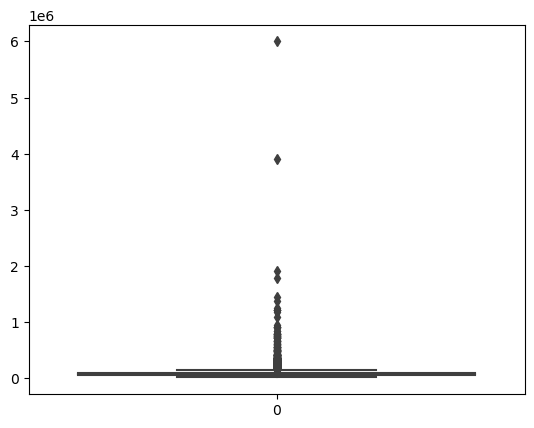

count    3.783500e+04
mean     6.967097e+04
std      6.364337e+04
min      4.000000e+03
25%      4.188600e+04
50%      6.000000e+04
75%      8.350000e+04
max      6.000000e+06
Name: annual_inc, dtype: float64

In [10]:
sns.boxplot(data['annual_inc'])
plt.show()
data['annual_inc'].describe()

From above column description we can see that the mean & median are of 10^4 order and max is of 10^6 order. Hence there are outliers
present in this column. Let us remove those outliers.

In [11]:
data = data[data['annual_inc'] < data['annual_inc'].quantile(0.98)] # remove outliers
data['annual_inc'].describe()

count     37075.000000
mean      64816.021619
std       32340.500407
min        4000.000000
25%       41000.000000
50%       59000.000000
75%       80232.000000
max      188004.000000
Name: annual_inc, dtype: float64

After removing outliers our **annual income** column is looking fine.

#### 3.2 Fix values and datatypes

#### 3.2.1 On interest rate column
Let us analyse interest rate column

In [12]:
print(data['int_rate'].head(2))
data['int_rate'].info()

0    10.65%
1    15.27%
Name: int_rate, dtype: object
<class 'pandas.core.series.Series'>
Index: 37075 entries, 0 to 39680
Series name: int_rate
Non-Null Count  Dtype 
--------------  ----- 
37075 non-null  object
dtypes: object(1)
memory usage: 579.3+ KB


We have to modify the data type of this column from object to float and remove the % from the end, to consider this column as a
quantitive variable during our analysis.

In [13]:
data['int_rate'] = data['int_rate'].apply(lambda x: x[0:-1])
data['int_rate'] = data['int_rate'].astype('float64')

In [14]:
print(data['int_rate'].head(2))
data['int_rate'].info()

0    10.65
1    15.27
Name: int_rate, dtype: float64
<class 'pandas.core.series.Series'>
Index: 37075 entries, 0 to 39680
Series name: int_rate
Non-Null Count  Dtype  
--------------  -----  
37075 non-null  float64
dtypes: float64(1)
memory usage: 579.3 KB


In [15]:
data.shape

(37075, 38)

# Univariate analysis on categorical variables

#### 1. Analysis on Loan Status
Below pie chart shows that most of the loan applications status are **'Fully Paid'** and only 13.84% applications are **'Charged Off'**.

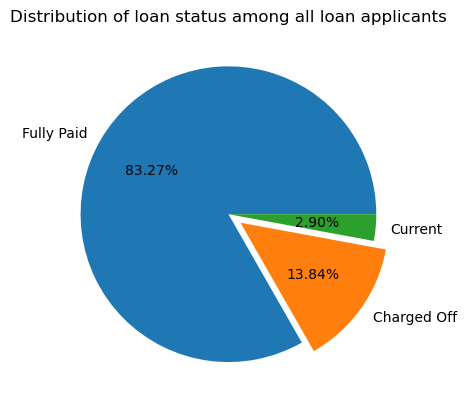

In [16]:
plt = reload(plt)
plt.pie(x = data['loan_status'].value_counts()*100 / len(data['loan_status']), autopct='%.2f%%', 
        labels=data['loan_status'].value_counts().index, explode = [0, 0.1, 0])
plt.title('Distribution of loan status among all loan applicants')
plt.show()

#### 2. Analysis on Loan Purpose
Below barchart shows that most of the loan applicants have loan purpose of **debt consolidators**.

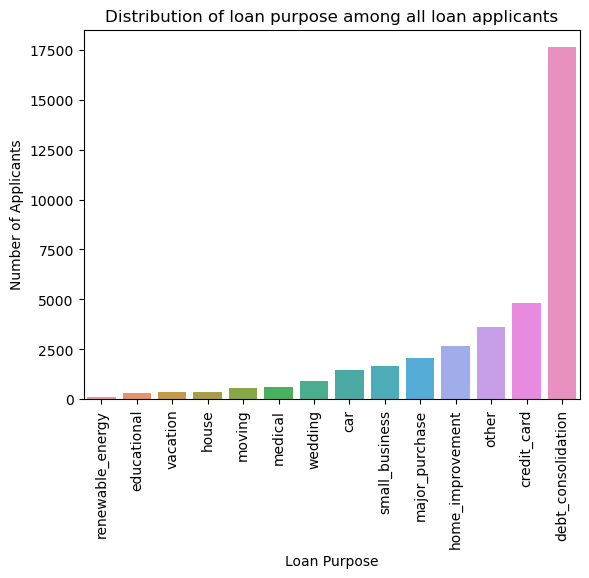

In [17]:
plt = reload(plt)
sns.barplot(y = data['purpose'].value_counts(ascending=True), x = data['purpose'].value_counts(ascending=True).index)
plt.xticks(rotation = 90)
plt.title('Distribution of loan purpose among all loan applicants')
plt.xlabel('Loan Purpose')
plt.ylabel('Number of Applicants')
plt.show()

#### 3. Analysis on Loan Term
Below pie chart shows that most of the applicants(**72.77%**) choose **36 months** term plan to repay the loan.

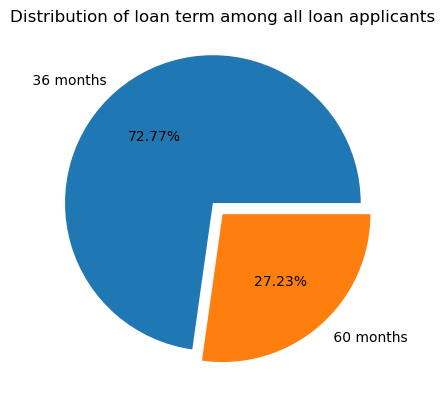

In [18]:
plt = reload(plt)
plt.pie(x = data['term'].value_counts()*100 / len(data['term']), autopct='%.2f%%', labels=data['term'].value_counts().index, 
        explode = [0.1, 0])
plt.title('Distribution of loan term among all loan applicants')
plt.show()

#### 4. Analysis on Employment Length
Below pie chart shows that the **majority** of the loan appliers having **10+ years** of service length.

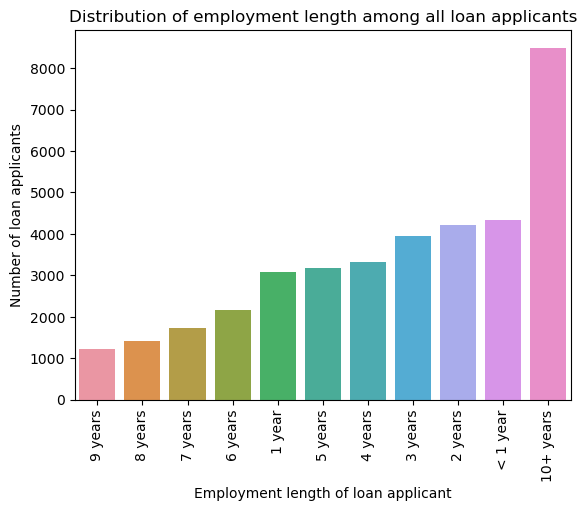

In [19]:
plt = reload(plt)
sns.barplot(x = data['emp_length'].value_counts(ascending=True).index, y = data['emp_length'].value_counts(ascending=True))
plt.xticks(rotation = 90)
plt.xlabel('Employment length of loan applicant')
plt.ylabel('Number of loan applicants')
plt.title('Distribution of employment length among all loan applicants')
plt.show()

#### 5. Analysis on House Ownership
Below barchart shows that **majority** of the loan applicants are either resides in **rented house** or they **mortgage their houses**.

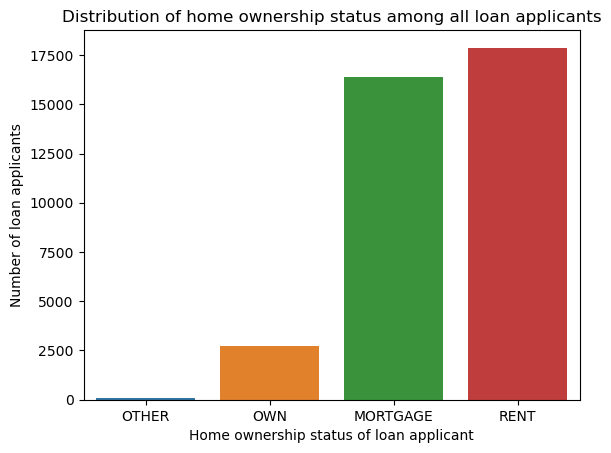

In [20]:
plt = reload(plt)
sns.barplot(x = data['home_ownership'].value_counts(ascending=True).index, 
            y = data['home_ownership'].value_counts(ascending=True))
plt.xlabel('Home ownership status of loan applicant')
plt.ylabel('Number of loan applicants')
plt.title('Distribution of home ownership status among all loan applicants')
plt.show()

#### 6. Analysis on Verification Status
Below pie chart shows that **42.08%** people's income are **not verified** by LC.

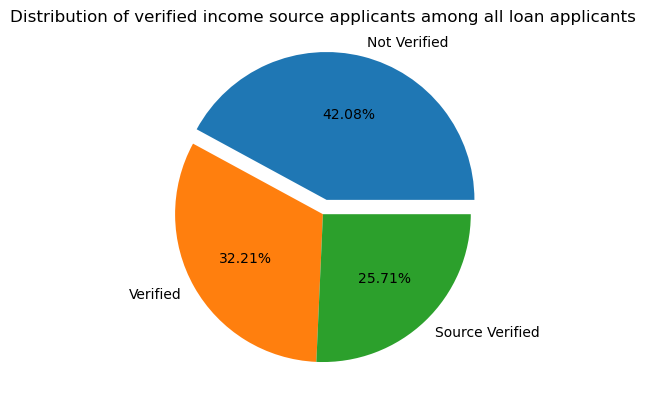

In [21]:
plt = reload(plt)
plt.pie(x = data['verification_status'].value_counts()*100 / len(data['verification_status']), autopct='%.2f%%', 
        labels=data['verification_status'].value_counts().index, explode = [0.1, 0, 0])
plt.title('Distribution of verified income source applicants among all loan applicants')
plt.show()

#### 7. Analysis on State
Below bar chart shows that **state CA** has **highest** loan applications.

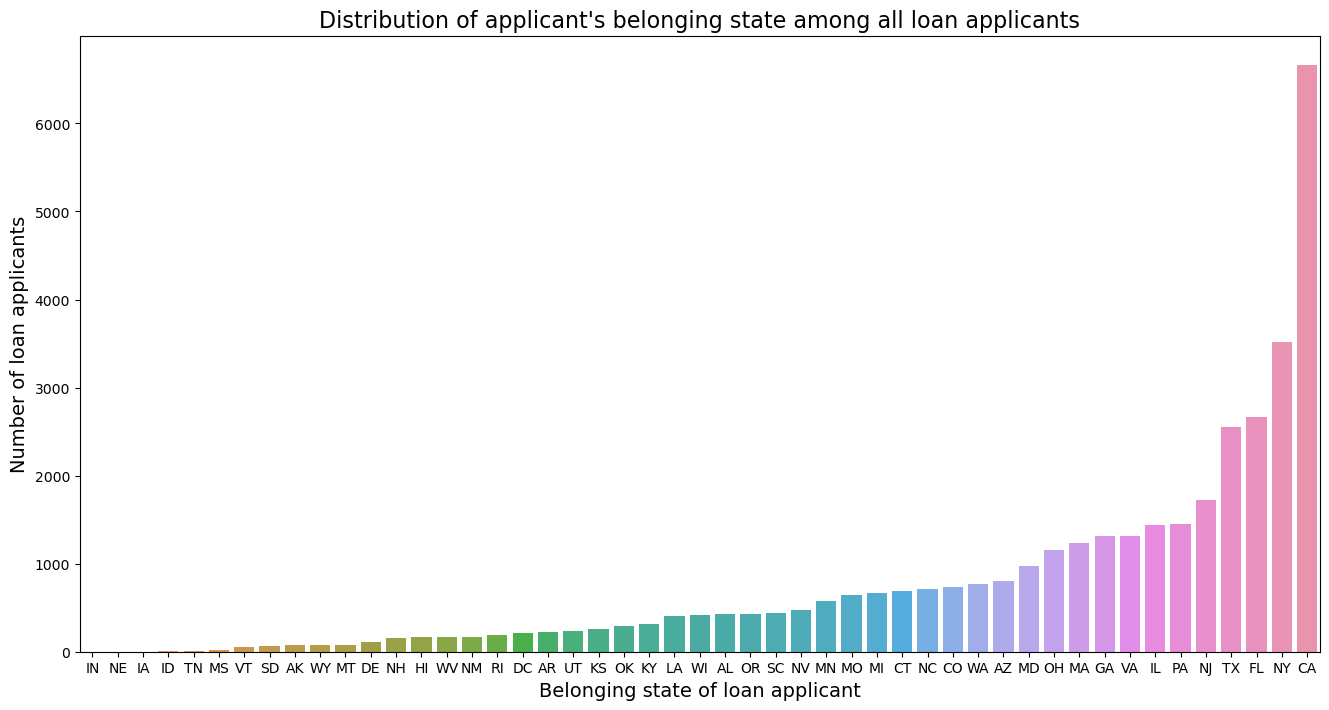

In [22]:
plt = reload(plt)
plt.figure(figsize = (16, 8))
sns.barplot(x = data['addr_state'].value_counts(ascending=True).index, y = data['addr_state'].value_counts(ascending=True))
plt.xlabel('Belonging state of loan applicant', fontsize=14)
plt.ylabel('Number of loan applicants', fontsize=14)
plt.title("Distribution of applicant's belonging state among all loan applicants", fontsize=16)
plt.show()

#### 8. Analysis on Grade
LC assigns **A and B grade** to mostly applicants.

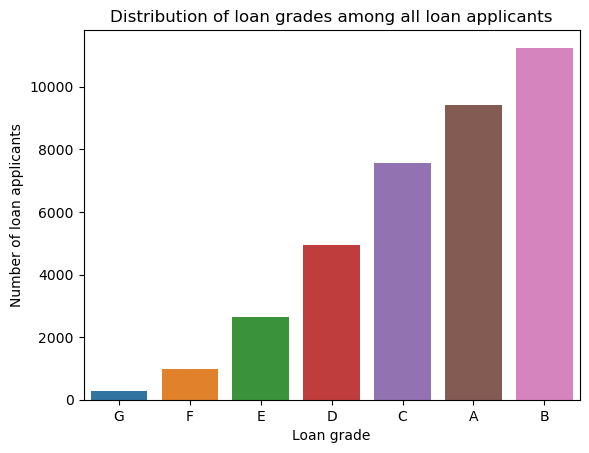

In [23]:
plt = reload(plt)
sns.barplot(x = data['grade'].value_counts(ascending=True).index, y = data['grade'].value_counts(ascending=True))
plt.xlabel('Loan grade')
plt.ylabel('Number of loan applicants')
plt.title("Distribution of loan grades among all loan applicants")
plt.show()

#### 9. Analysis on Public Record Bankruptcies
Very few applicants are officially bankrupt.

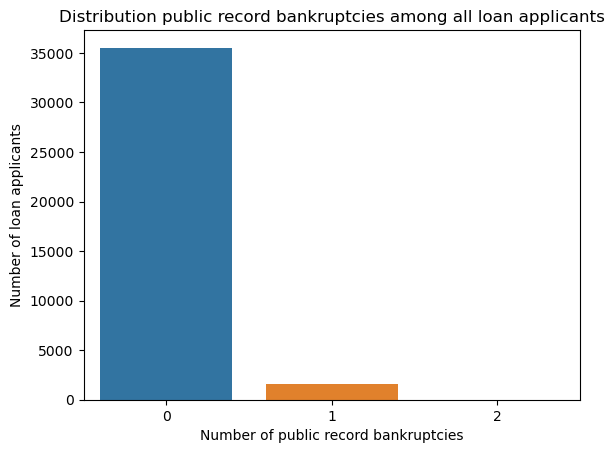

In [24]:
plt = reload(plt)
data['pub_rec_bankruptcies'] = data['pub_rec_bankruptcies'].astype('int32')
sns.barplot(x = data['pub_rec_bankruptcies'].value_counts(ascending=True).index, 
            y = data['pub_rec_bankruptcies'].value_counts(ascending=True))
plt.xlabel('Number of public record bankruptcies')
plt.ylabel('Number of loan applicants')
plt.title("Distribution public record bankruptcies among all loan applicants")
plt.show()

# Univariate analysis on quantitive variables

#### 1. Analysis on Loan Amount
Below plots are showing that the most of the loan applicants are applying for the **amount range between 5000 rs to 15000 rs.**

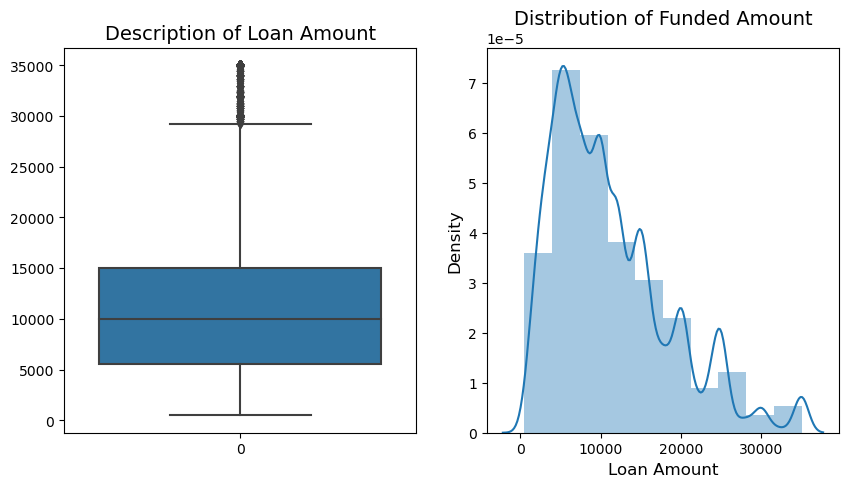

In [25]:
plt = reload(plt)
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
ax = sns.boxplot(data['loan_amnt'])
ax.set_title('Description of Loan Amount', fontsize=14)

plt.subplot(1,2,2)
ax = sns.distplot(data['loan_amnt'], bins=10)
ax.set_title('Distribution of Funded Amount', fontsize=14)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xlabel('Loan Amount', fontsize = 12)

plt.show()

#### 2. Analysis on Funded Amount
Below plots are showing that the bank is funding the most of the loan applicants **amount range between 5000 rs to 15000 rs.**

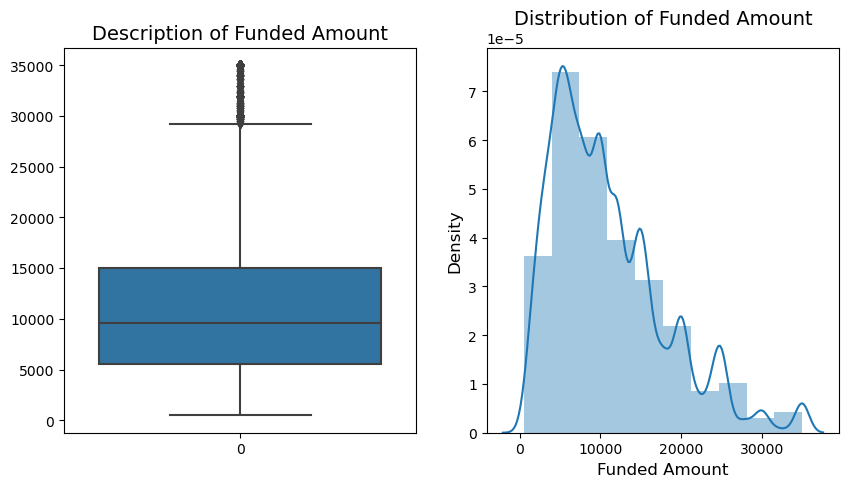

In [26]:
plt = reload(plt)
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
ax = sns.boxplot(data['funded_amnt'])
ax.set_title('Description of Funded Amount', fontsize=14)

plt.subplot(1,2,2)
ax = sns.distplot(data['funded_amnt'], bins=10)
ax.set_title('Distribution of Funded Amount', fontsize=14)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xlabel('Funded Amount', fontsize = 12)

plt.show()

#### 3. Analysis on Interest Rate
Below plots are showing that the bank is providing the loan with **interest rate between 8% to 15%** to most of the loan applicants.

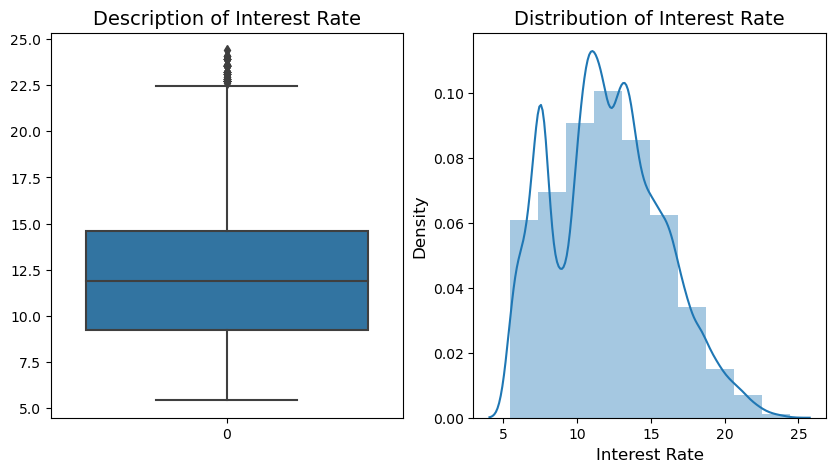

In [27]:
plt = reload(plt)
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
ax = sns.boxplot(data['int_rate'])
ax.set_title('Description of Interest Rate', fontsize=14)

plt.subplot(1,2,2)
ax = sns.distplot(data['int_rate'], bins=10)
ax.set_title('Distribution of Interest Rate', fontsize=14)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xlabel('Interest Rate', fontsize = 12)

plt.show()

#### 4. Analysis on Monthly Installments
Below plots are showing that the loan applicants are giving **190 rs to 400 rs monthly installemnts** to replay their loan.

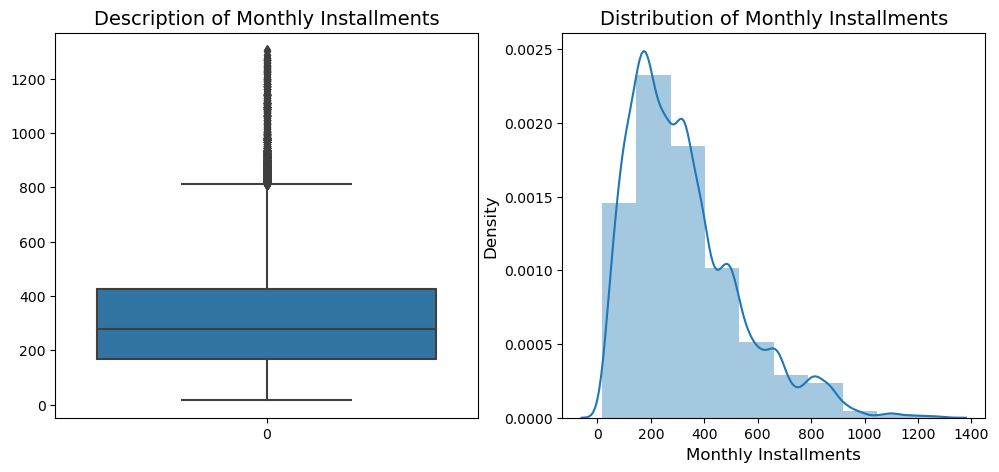

In [28]:
plt = reload(plt)
plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
ax = sns.boxplot(data['installment'])
ax.set_title('Description of Monthly Installments', fontsize=14)

plt.subplot(1,2,2)
ax = sns.distplot(data['installment'], bins=10)
ax.set_title('Distribution of Monthly Installments', fontsize=14)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xlabel('Monthly Installments', fontsize = 12)

plt.show()

#### 4. Analysis on Annual Income
Below plots are showing that the loan applicants have thier **annual income in between 40,000 rs to 80,000 rs.**

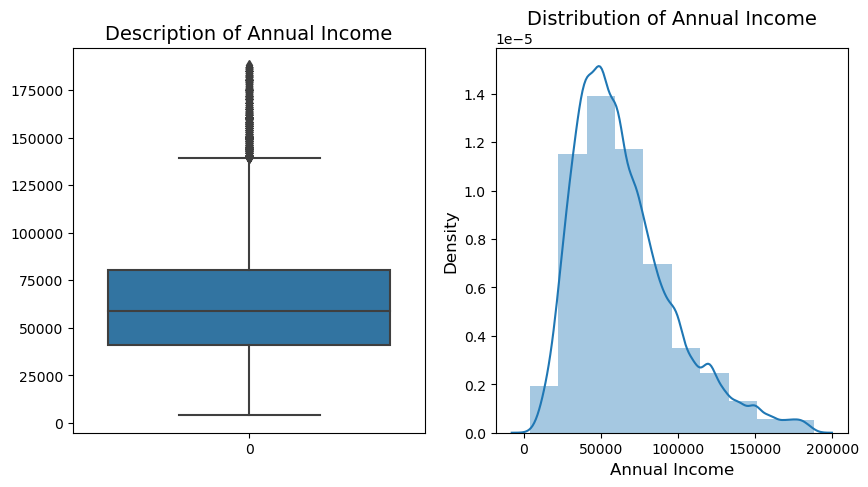

In [29]:
plt = reload(plt)
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
ax = sns.boxplot(data['annual_inc'])
ax.set_title('Description of Annual Income', fontsize=14)

plt.subplot(1,2,2)
ax = sns.distplot(data['annual_inc'], bins=10)
ax.set_title('Distribution of Annual Income', fontsize=14)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xlabel('Annual Income', fontsize = 12)

plt.show()

#### 5. Analysis on Revolving Balance
Below plots are showing that for most of the loan applicants the range of upaid amount at the end of their billing cycle is in between **4000 rs to 17000 rs**

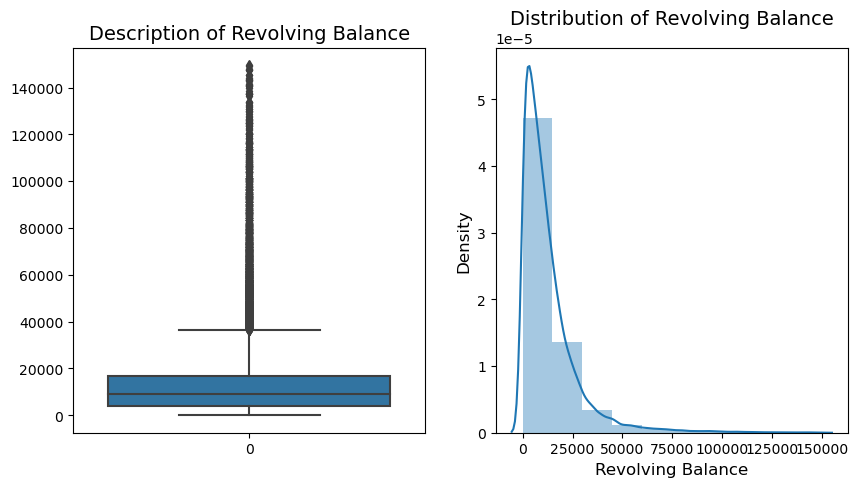

In [30]:
plt = reload(plt)
plt.figure(figsize = (10, 5))

plt.subplot(1,2,1)
ax = sns.boxplot(data['revol_bal'])
ax.set_title('Description of Revolving Balance', fontsize=14)

plt.subplot(1,2,2)
ax = sns.distplot(data['revol_bal'], bins=10)
ax.set_title('Distribution of Revolving Balance', fontsize=14)
ax.set_ylabel('Density', fontsize = 12)
ax.set_xlabel('Revolving Balance', fontsize = 12)

plt.show()

# Derived matrices

#### 1. Derive year from loan issue date

In [31]:
data['issue_year'] = (pd.to_datetime(data['issue_d'], format = '%b-%y')).dt.year

#### Loan applications over the year
Below bar chart shows that the number of loan applications are increase over the year from 2007-2011.

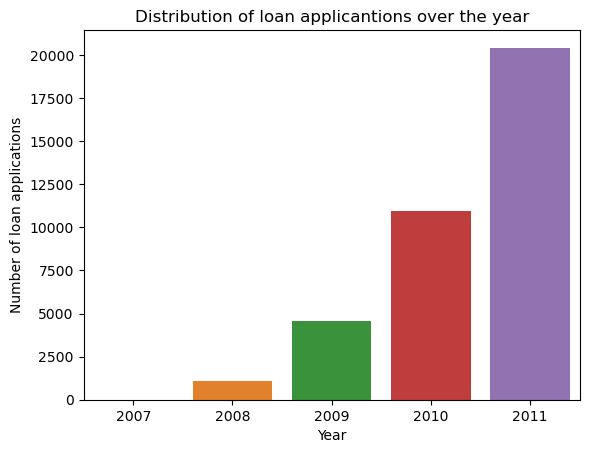

In [32]:
plt = reload(plt)

sns.barplot(y = data['issue_year'].value_counts(ascending = True), x = data['issue_year'].value_counts(ascending = True).index)
plt.xlabel('Year')
plt.ylabel('Number of loan applications')
plt.title("Distribution of loan applicantions over the year")
plt.show()

#### 2. Derive annual income categories from annual income

In [33]:
data['inc_cat'] = pd.cut(data['annual_inc'], [0, 25000, 50000, 75000, 100000, 1250000], 
                                 labels=['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000 +'])

Below bar chart shows that most of the loan applicants are belong to 25,000-50,000 annual income.

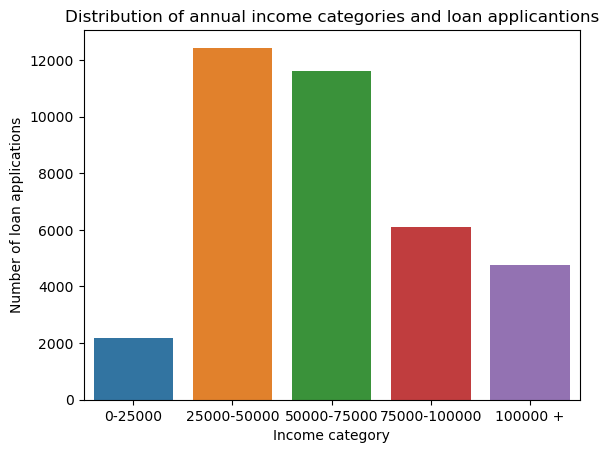

In [34]:
plt = reload(plt)

sns.barplot(y = data['inc_cat'].value_counts(ascending = True), x = data['inc_cat'].value_counts(ascending = True).index)
plt.xlabel('Income category')
plt.ylabel('Number of loan applications')
plt.title("Distribution of annual income categories and loan applicantions")
plt.show()

Let us club all the categorical and numerical columns together, then we have lists like follows:

In [35]:
categorical_columns = ['loan_status', 'purpose', 'term', 'emp_length', 'home_ownership', 'verification_status', 'addr_state', 
                       'grade', 'pub_rec_bankruptcies', 'inc_cat']

numeric_columns = ['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'revol_bal']

# Bivariate analysis

#### 1. Analyse on Interest Rate vs Revolving Balance
Below scatter plot between interest rate and revolving balance shows that loan applicants who have **loan of low interest rate are likely to unpaind their amount at the end of their billing cycle(the revolving balance is high)**, compared to loan applicants who have loan of high interest rate.

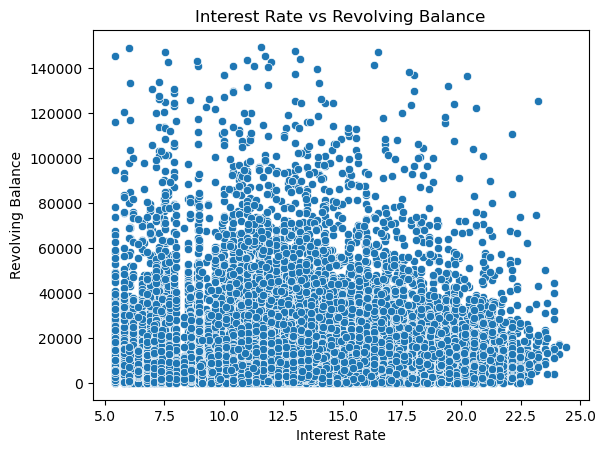

In [36]:
plt = reload(plt)
sns.scatterplot(x = data['int_rate'], y = data['revol_bal'])
plt.title('Interest Rate vs Revolving Balance')
plt.xlabel('Interest Rate')
plt.ylabel('Revolving Balance')
plt.show()

#### 2. Analyse on Annual Income vs Revolving Balance
Below scatter plot between annual income and revolving balance shows that loan applicants who have **high annual income are likely to unpaind their amount at the end of their billing cycle(the revolving balance is high)**, compared to loan applicants who have low annual income.

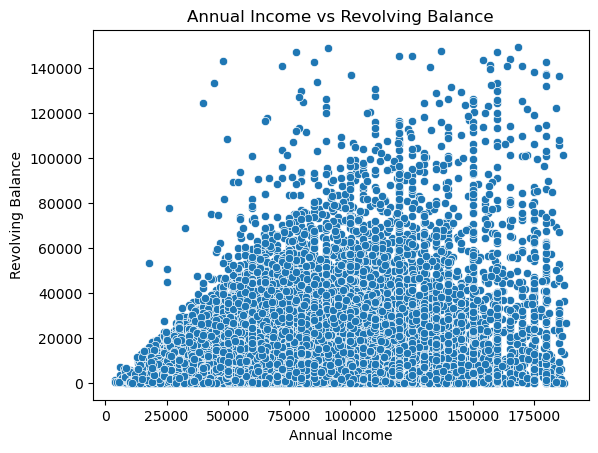

In [37]:
plt = reload(plt)
sns.scatterplot(x = data['annual_inc'], y = data['revol_bal'])
plt.title('Annual Income vs Revolving Balance')
plt.xlabel('Annual Income')
plt.ylabel('Revolving Balance')
plt.show()

#### 3. Analyse on Annual Income vs Installment
Below scatter plot between annual income and revolving balance shows that loan applicants who have **high annual income are giving high installments**, compared to loan applicants who have low annual income.

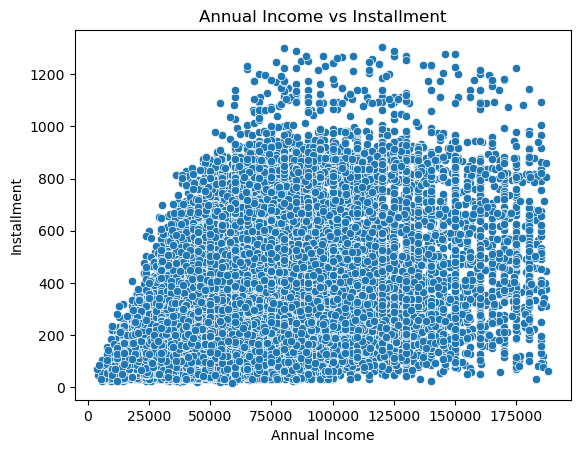

In [38]:
plt = reload(plt)
sns.scatterplot(x = data['annual_inc'], y = data['installment'])
plt.title('Annual Income vs Installment')
plt.xlabel('Annual Income')
plt.ylabel('Installment')
plt.show()

#### 4. Analyse on Annual Income vs Loan Amount
Below scatter plot between annual income and loan amount shows that loan applicants who have **high annual income are taking bigger loan**, compared to loan applicants who have low annual income.

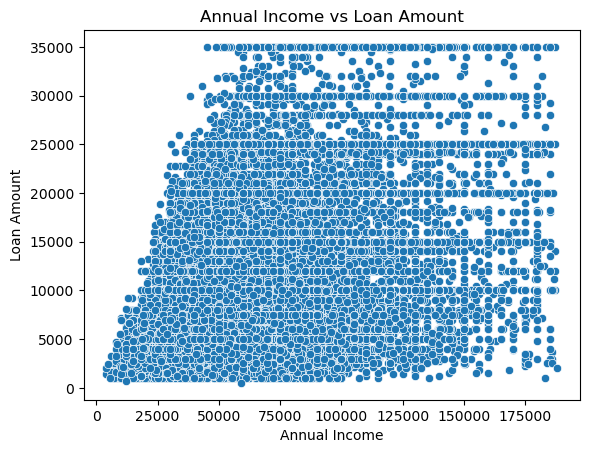

In [39]:
plt = reload(plt)
sns.scatterplot(x = data['annual_inc'], y = data['loan_amnt'])
plt.title('Annual Income vs Loan Amount')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')
plt.show()

#### 5. Analysis on Loan Status vs Annual Income
Below box plot comparison shows that 
* The **loan applicants who are "charged off" having less income than "fully paid" applicants.**
* The **loan applicants whose loan status is "current" are drawing highest salary among others.**

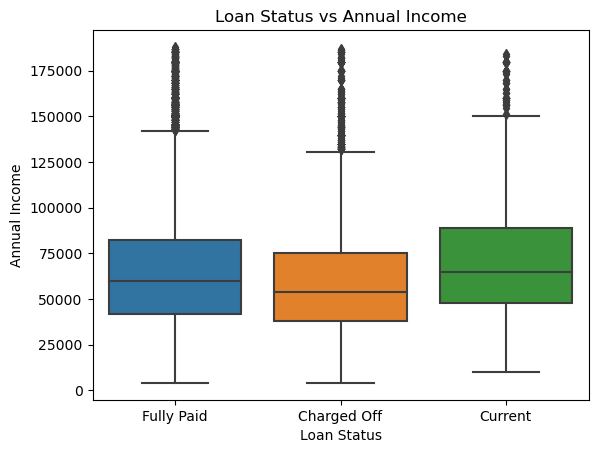

In [40]:
plt = reload(plt)
sns.boxplot(x = data['loan_status'], y = data['annual_inc'])
plt.title('Loan Status vs Annual Income')
plt.xlabel('Loan Status')
plt.ylabel('Annual Income')
plt.show()

#### 6. Analysis on Loan Status vs Interest Rate
Below box plot comparison shows that 
* The **loan applicants who are "charged off" having high loan interest rate than "fully paid" applicants.**
* The **loan applicants whose loan status is "current" having highest loan interest rate among others.**

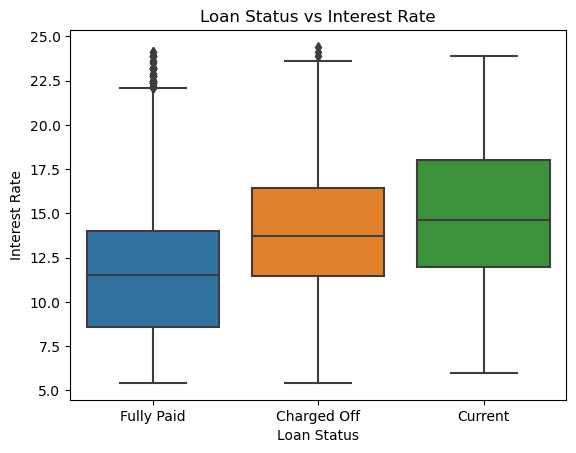

In [41]:
plt = reload(plt)
sns.boxplot(x = data['loan_status'], y = data['int_rate'])
plt.title('Loan Status vs Interest Rate')
plt.xlabel('Loan Status')
plt.ylabel('Interest Rate')
plt.show()

#### 7. Analysis on Loan Status vs Interest Rate
Below box plot comparison shows that 
* The **loan applicants whose loan status is "current" having highest monthly loan installment among others.**

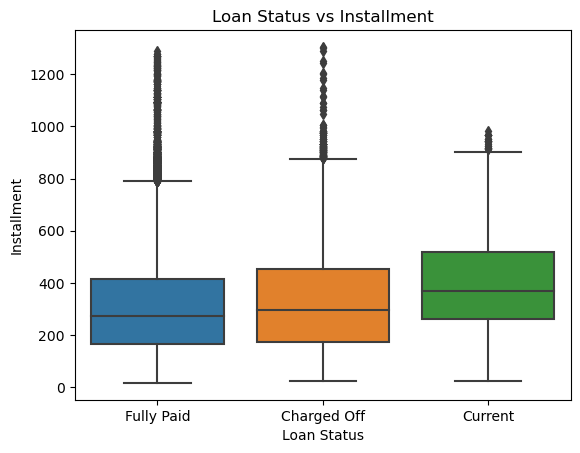

In [42]:
plt = reload(plt)
sns.boxplot(x = data['loan_status'], y = data['installment'])
plt.title('Loan Status vs Installment')
plt.xlabel('Loan Status')
plt.ylabel('Installment')
plt.show()

#### 8. Analysis on Loan Purpose vs Loan Amount
Below bar plot comparison shows that 
* **Majority** of loan applicants applies loan for either for **small business or for house.**
* **Very less** loan applications have **vacation** as their loan purpose

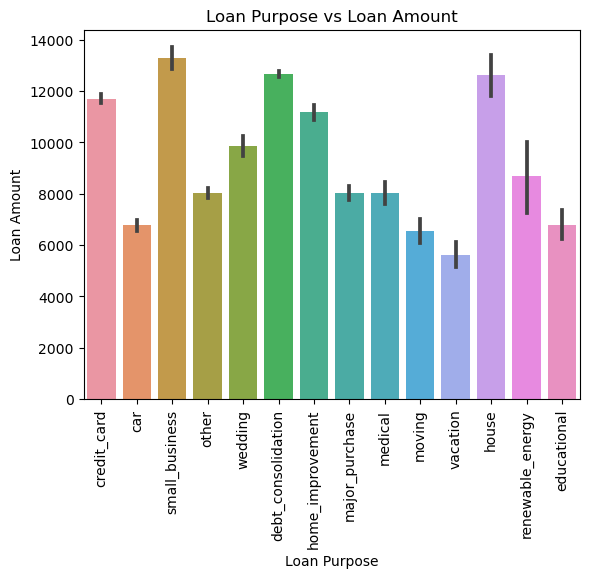

In [43]:
plt = reload(plt)
sns.barplot(x = data['purpose'], y = data['loan_amnt'])
plt.title('Loan Purpose vs Loan Amount')
plt.xlabel('Loan Purpose')
plt.ylabel('Loan Amount')
plt.xticks(rotation = 90)
plt.show()

#### 9. Analysis on Loan Term vs Loan Amount
Below box plot comparison shows that 
* Loan amount for **60 months term is greater** than loan amount for 36 months.


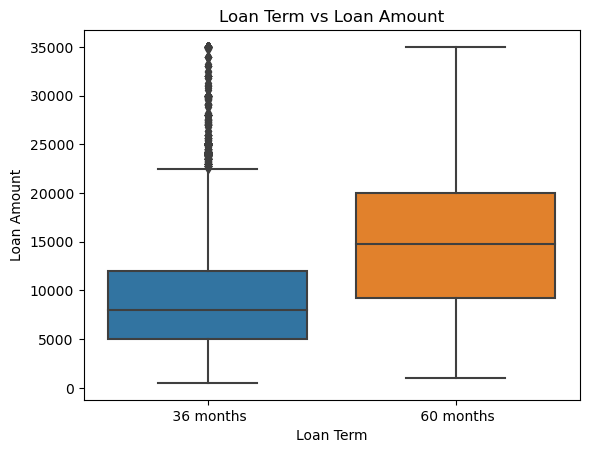

In [44]:
plt = reload(plt)
sns.boxplot(x = data['term'], y = data['loan_amnt'])
plt.title('Loan Term vs Loan Amount')
plt.xlabel('Loan Term')
plt.ylabel('Loan Amount')
plt.show()

#### 10. Analysis on Employment Length vs Loan Amount
Below bar plot comparison shows that 
* Loan applicants who have **more than 10 years** of working are taking **highest** amount of loan.
* Loan applicants who have **less than 1 year** of working are taking **lowest** amount of loan.

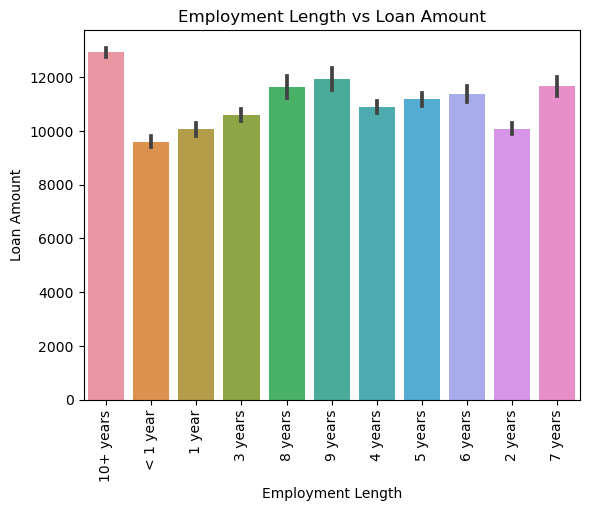

In [45]:
plt = reload(plt)
sns.barplot(x = data['emp_length'], y = data['loan_amnt'])
plt.title('Employment Length vs Loan Amount')
plt.xlabel('Employment Length')
plt.ylabel('Loan Amount')
plt.xticks(rotation = 90)
plt.show()

#### 11. Analysis on Home Ownership vs Loan Amount
Below box plot comparison shows that 
* Loan applicants who are **mortgage**, are taking **highest** amounnt of loan.

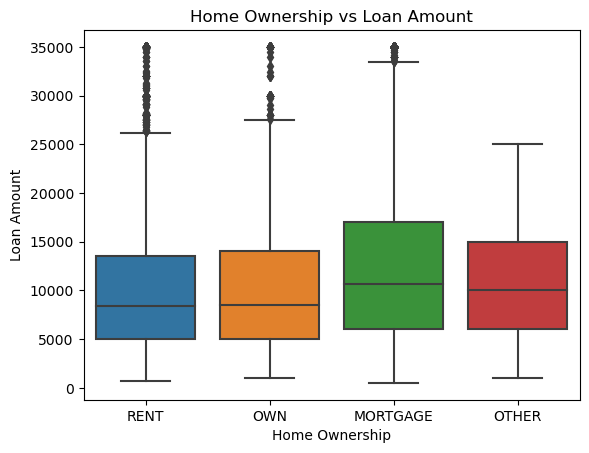

In [46]:
plt = reload(plt)
sns.boxplot(x = data['home_ownership'], y = data['loan_amnt'])
plt.title('Home Ownership vs Loan Amount')
plt.xlabel('Home Ownership')
plt.ylabel('Loan Amount')
plt.show()

#### 12. Analysis on Address State vs Loan Amount
Below bar plot comparison shows that 
* Loan applicants who belong from **state AK** are taking **highest** amont of loan.
* Loan applicants who belong from **state IN** are taking **lowest** amount loan.

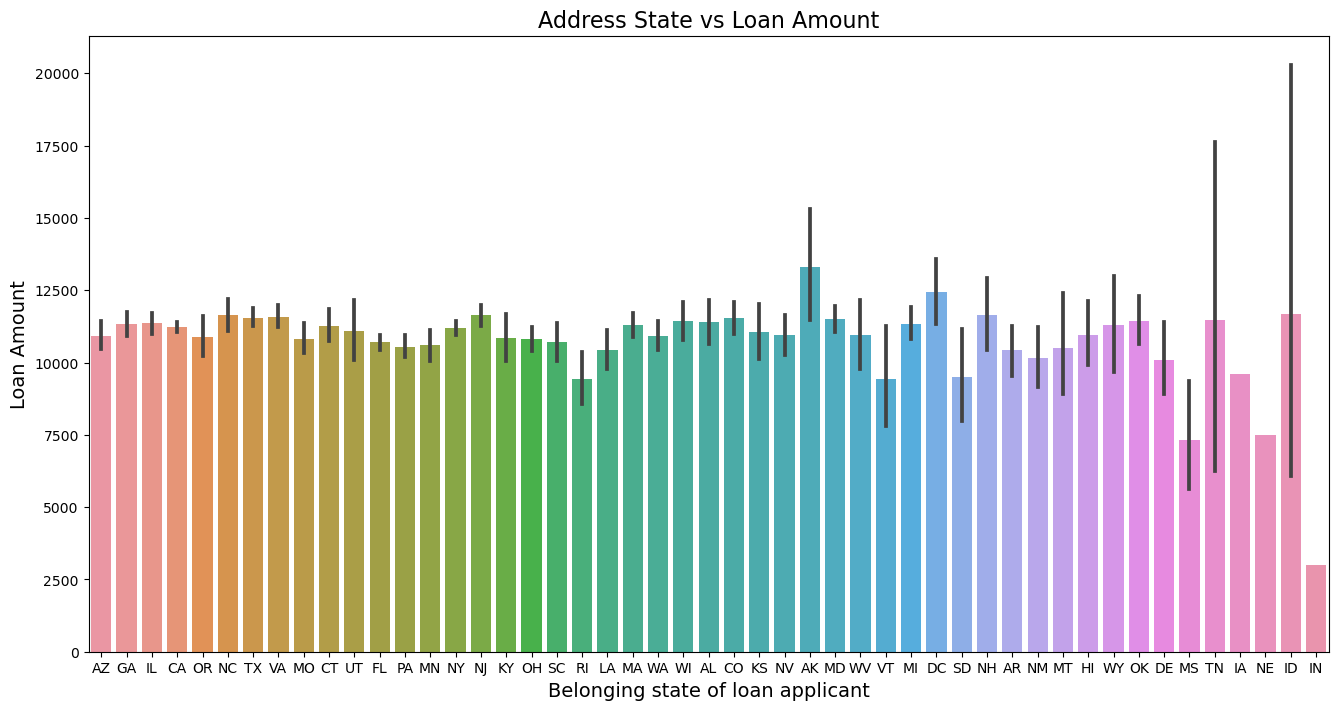

In [47]:
plt = reload(plt)
plt.figure(figsize = (16, 8))
sns.barplot(x = data['addr_state'], y = data['loan_amnt'])
plt.xlabel('Belonging state of loan applicant', fontsize=14)
plt.ylabel('Loan Amount', fontsize=14)
plt.title('Address State vs Loan Amount', fontsize=16)
plt.show()

#### 13. Analysis on Public Record Bankrupticies vs Loan Amount
Below bar plot comparison shows that 
* Loan applicants who have **2 bankrupticies** are taking **highest** amount of loan.

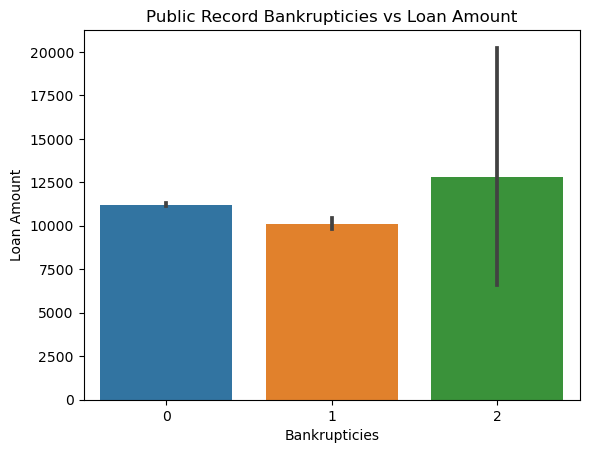

In [48]:
plt = reload(plt)
sns.barplot(x = data['pub_rec_bankruptcies'], y = data['loan_amnt'])
plt.title('Public Record Bankrupticies vs Loan Amount')
plt.xlabel('Bankrupticies')
plt.ylabel('Loan Amount')
plt.show()

#### 14. Analysis on Loan Status vs Public Record Bankrupticies
Below bar plot comparison shows that 
* Loan applicants who are **charged-off** are **bankrupt**.

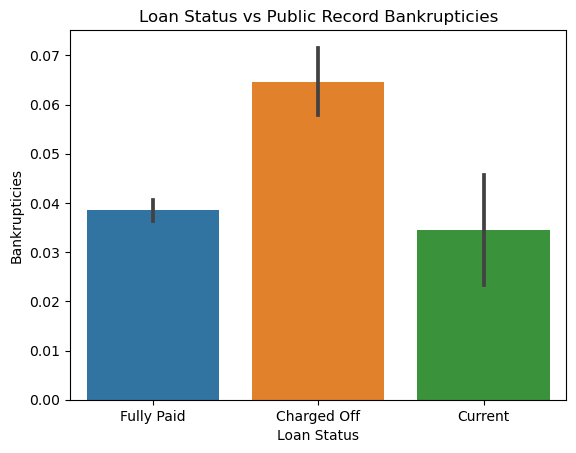

In [49]:
plt = reload(plt)
sns.barplot(x = data['loan_status'], y = data['pub_rec_bankruptcies'])
plt.title('Loan Status vs Public Record Bankrupticies')
plt.ylabel('Bankrupticies')
plt.xlabel('Loan Status')
plt.show()

#### 15. Analysis on Employment Length vs Public Record Bankrupticies
Below bar plot comparison shows that 
* Loan applicants who have **10+ years of employment length** are mostly **bankrupt**.

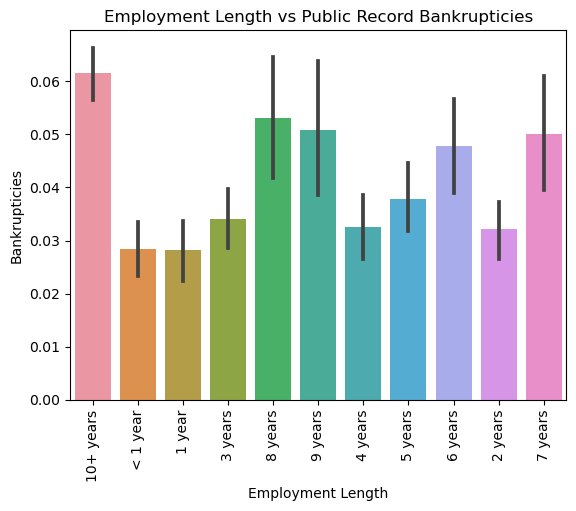

In [50]:
plt = reload(plt)
sns.barplot(x = data['emp_length'], y = data['pub_rec_bankruptcies'])
plt.title('Employment Length vs Public Record Bankrupticies')
plt.ylabel('Bankrupticies')
plt.xlabel('Employment Length')
plt.xticks(rotation = 90)
plt.show()

#### 16. Analysis on LC Verification vs Public Record Bankrupticies
Below bar plot comparison shows that 
* Loan applicants whose employment source are **not verified by LC** are mostly **bankrupt**.

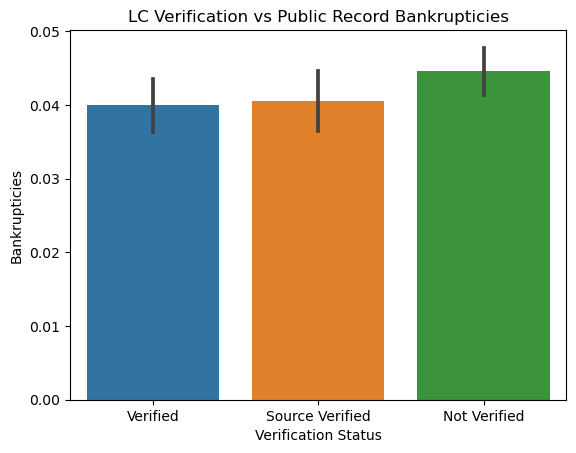

In [51]:
plt = reload(plt)
sns.barplot(x = data['verification_status'], y = data['pub_rec_bankruptcies'])
plt.title('LC Verification vs Public Record Bankrupticies')
plt.ylabel('Bankrupticies')
plt.xlabel('Verification Status')
plt.show()

# Multivariate Analysis
Below heatmap shows
* All numeric variables are positively co-related.
* **Loan amount and Funded amount** are **highly co-related.**
* **Annual income and Interest rate** are **less co-related.**
* There is **no inverse relation** among any of variables.

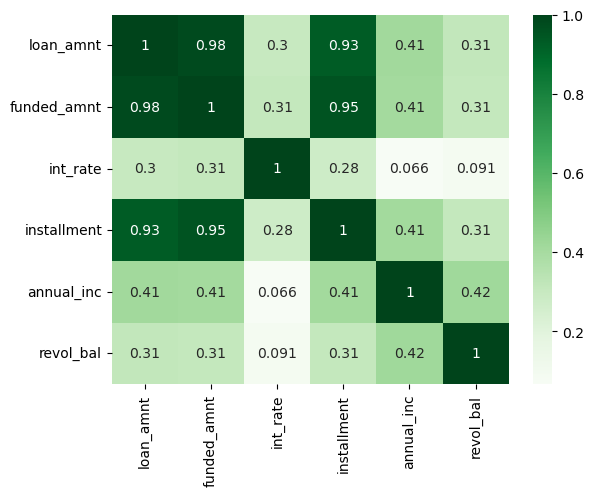

In [52]:
sns.heatmap(data[numeric_columns].corr(), annot = True, cmap = 'Greens')
plt.show()

# Segmented analysis

#### 1. Analysis on  Annual Income Categories vs Charged Off Percentage
Below bar charts shows:
* People who earn **between 0-25,000** are **most likely to 'charged off'**.
* People who earn **more than 100,000** are **less likely to 'charged off'**.

In [53]:
basis_of_segmentation = ['inc_cat', 'loan_status']

df = data.groupby(by = basis_of_segmentation)['loan_status'].count().unstack().reset_index()

df['total'] = df['Charged Off'] + df['Current'] + df['Fully Paid']
df['charged_off_per(%)'] = (df['Charged Off'] / df['total']) * 100

df

loan_status,inc_cat,Charged Off,Current,Fully Paid,total,charged_off_per(%)
0,0-25000,391,16,1778,2185,17.894737
1,25000-50000,1952,312,10166,12430,15.703942
2,50000-75000,1591,348,9658,11597,13.719065
3,75000-100000,699,218,5171,6088,11.481603
4,100000 +,497,180,4098,4775,10.408377


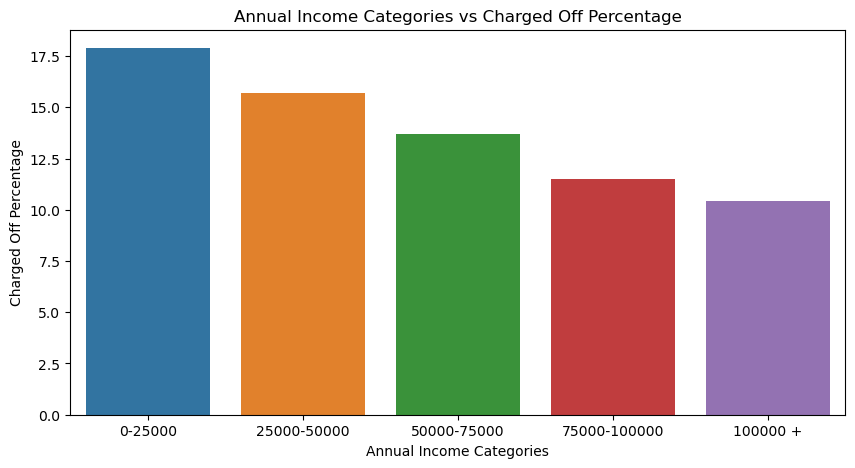

In [54]:
plt = reload(plt)

plt.figure(figsize = (10, 5))
sns.barplot(x = df['inc_cat'], y = df['charged_off_per(%)'])
plt.title('Annual Income Categories vs Charged Off Percentage')
plt.ylabel('Charged Off Percentage')
plt.xlabel('Annual Income Categories')

plt.show()

#### 2. Analysis on  Loan Purpose vs Charged Off Percentage
Below bar charts shows:
* People who are taking loan for **small business** are **most likely to 'charged off'**.
* People who are taking loan for **wedding** are **less likely to 'charged off'**.

In [55]:
basis_of_segmentation = ['purpose', 'loan_status']

df = data.groupby(by = basis_of_segmentation)['loan_status'].count().unstack().fillna(0).reset_index()

df['total'] = df['Charged Off'] + df['Current'] + df['Fully Paid']
df['charged_off_per(%)'] = (df['Charged Off'] / df['total']) * 100
df = df.sort_values('charged_off_per(%)', ascending=False)

df

loan_status,purpose,Charged Off,Current,Fully Paid,total,charged_off_per(%)
11,small_business,432.0,72.0,1166.0,1670.0,25.868263
10,renewable_energy,16.0,1.0,72.0,89.0,17.977528
3,educational,46.0,0.0,243.0,289.0,15.916955
7,medical,99.0,10.0,528.0,637.0,15.541601
5,house,54.0,14.0,280.0,348.0,15.517241
9,other,555.0,116.0,2962.0,3633.0,15.276631
8,moving,79.0,7.0,453.0,539.0,14.656772
12,vacation,50.0,4.0,288.0,342.0,14.619883
2,debt_consolidation,2572.0,558.0,14502.0,17632.0,14.587114
4,home_improvement,305.0,88.0,2297.0,2690.0,11.338290


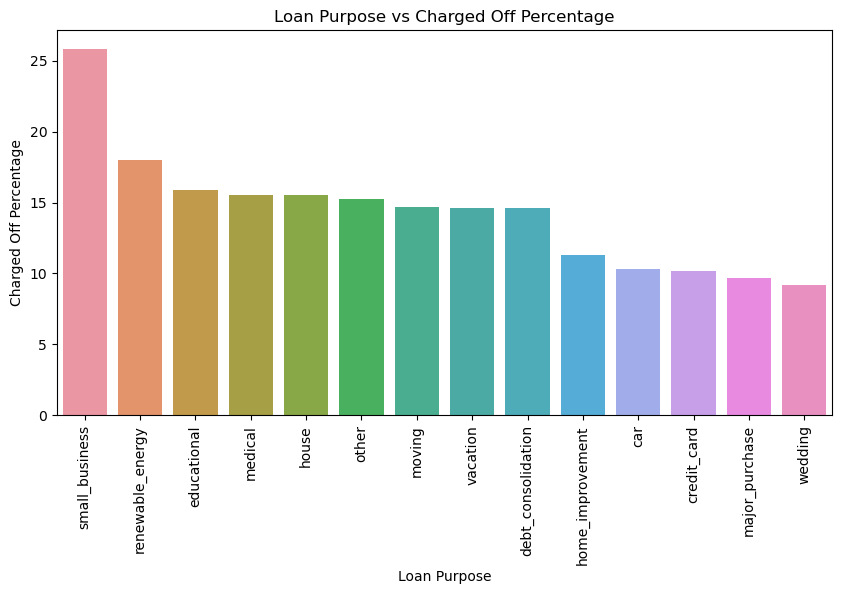

In [56]:
plt = reload(plt)

plt.figure(figsize = (10, 5))
sns.barplot(x = df['purpose'], y = df['charged_off_per(%)'])
plt.title('Loan Purpose vs Charged Off Percentage')
plt.ylabel('Charged Off Percentage')
plt.xlabel('Loan Purpose')
plt.xticks(rotation = 90)

plt.show()

#### 3. Analysis on  Loan Grade vs Charged Off Percentage
Below bar charts shows:
* People who belongs from grade **F and G** are **most likely to 'charged off'**.
* People who belongs from grade **A** are **less likely to 'charged off'**.

In [57]:
basis_of_segmentation = ['grade', 'loan_status']

df = data.groupby(by = basis_of_segmentation)['loan_status'].count().unstack().fillna(0).reset_index()

df['total'] = df['Charged Off'] + df['Current'] + df['Fully Paid']
df['charged_off_per(%)'] = (df['Charged Off'] / df['total']) * 100

df

loan_status,grade,Charged Off,Current,Fully Paid,total,charged_off_per(%)
0,A,545,35,8835,9415,5.788635
1,B,1295,323,9630,11248,11.513158
2,C,1220,254,6083,7557,16.143972
3,D,1023,210,3708,4941,20.704311
4,E,661,169,1825,2655,24.896422
5,F,294,67,605,966,30.434783
6,G,92,16,185,293,31.399317


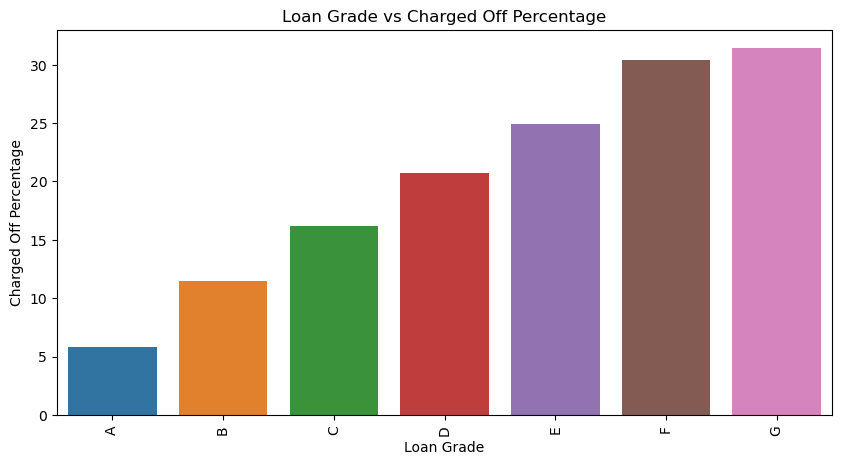

In [58]:
plt = reload(plt)

plt.figure(figsize = (10, 5))
sns.barplot(x = df['grade'], y = df['charged_off_per(%)'])
plt.title('Loan Grade vs Charged Off Percentage')
plt.ylabel('Charged Off Percentage')
plt.xlabel('Loan Grade')
plt.xticks(rotation = 90)

plt.show()

#### 4. Analysis on  Address State vs Charged Off Percentage
Below bar charts shows:
* People who belongs from state **NV, TN and AK** are **most likely to 'charged off'**.
* People who belongs from state **IN, ID and IA** are **less likely to 'charged off'**.

In [59]:
basis_of_segmentation = ['addr_state', 'loan_status']

df = data.groupby(by = basis_of_segmentation)['loan_status'].count().unstack().fillna(0).reset_index()

df['total'] = df['Charged Off'] + df['Current'] + df['Fully Paid']
df['charged_off_per(%)'] = (df['Charged Off'] / df['total']) * 100
df = df.sort_values('charged_off_per(%)', ascending=False)

df

loan_status,addr_state,Charged Off,Current,Fully Paid,total,charged_off_per(%)
31,NV,99.0,17.0,355.0,471.0,21.019108
40,TN,2.0,0.0,8.0,10.0,20.000000
0,AK,14.0,2.0,59.0,75.0,18.666667
39,SD,11.0,2.0,48.0,61.0,18.032787
9,FL,452.0,82.0,2137.0,2671.0,16.922501
30,NM,29.0,3.0,140.0,172.0,16.860465
11,HI,28.0,7.0,132.0,167.0,16.766467
23,MO,103.0,15.0,527.0,645.0,15.968992
35,OR,68.0,16.0,345.0,429.0,15.850816
10,GA,200.0,37.0,1072.0,1309.0,15.278839


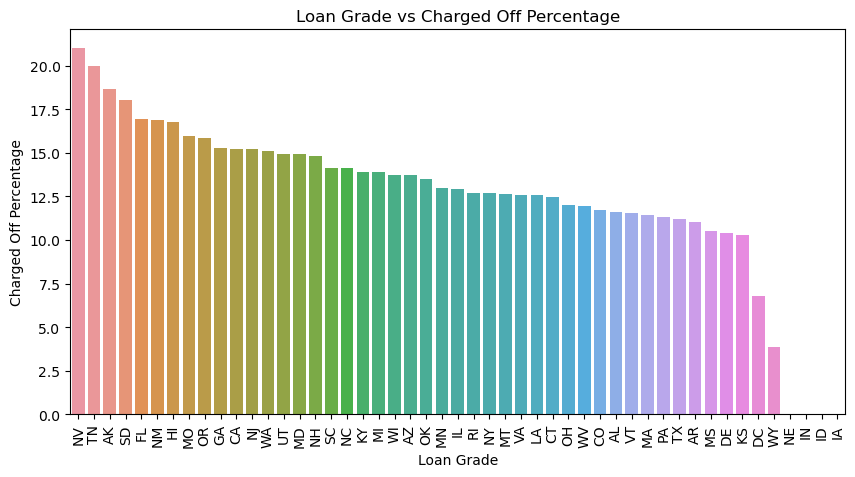

In [60]:
plt = reload(plt)

plt.figure(figsize = (10, 5))
sns.barplot(x = df['addr_state'], y = df['charged_off_per(%)'])
plt.title('Loan Grade vs Charged Off Percentage')
plt.ylabel('Charged Off Percentage')
plt.xlabel('Loan Grade')
plt.xticks(rotation = 90)

plt.show()